In [56]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from pacmagic_deeplearning.modeling.classifiers.bayesian.train_utils import make_performance_uncertainty_plot, cross_entropy


In [2]:
X_train = pd.read_csv('../../data/MIMIC/X_train_processed.csv')
y_train = pd.read_csv('../../data/MIMIC/y_train.csv')

X_test = pd.read_csv('../../data/MIMIC/X_test_processed.csv')
y_test = pd.read_csv('../../data/MIMIC/y_test.csv')

In [3]:
q_lower = np.linspace(0, y_train.mean(), 5)
q_upper = np.linspace(y_train.mean(), 1, 5)

In [4]:
quantiles = np.concatenate((q_lower, q_upper))

In [5]:
quantiles = np.insert(quantiles, 3, 0.5)

In [6]:
# quantiles = [y_train.mean() - .05, y_train.mean(), y_train.mean() + 0.05]

In [7]:
quantiles = np.linspace(0, 1, 11)

In [8]:
quantiles

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [9]:
def get_weight_tensor_from_class_weights(y, class_weights: list):
    weights = torch.empty_like(y).float()
    
    for i, weight in enumerate(class_weights):
        weights[y == i] = weight.item()
    
    return weights
        

In [10]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.z = nn.Linear(44, 64)
        self.quantile_preds = nn.ModuleList([nn.Linear(64, 1) for _ in range(len(quantiles))])
        
    def forward(self, x):
        z = self.z(x)
        return [self.quantile_preds[i](z) for i in range(len(self.quantile_preds))]

In [11]:
model = NN()

In [12]:
data = torch.from_numpy(X_train.values).float()
target = torch.from_numpy(y_train.values).float()

In [13]:
data_val = torch.from_numpy(X_test.values).float()
target_val = torch.from_numpy(y_test.values).float()

In [14]:
from torch.optim import SGD

In [15]:
optimizer = SGD(model.parameters(), lr=5e-1, momentum=0.9, nesterov=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [16]:
best_val_loss = np.inf
patience = 0

for epoch_idx in range(10000):
    outputs = model(data)
    losses = [torch.nn.functional.binary_cross_entropy_with_logits(
        outputs[i], 
        target, 
        weight=get_weight_tensor_from_class_weights(target, [quantiles[i], 1 - quantiles[i]])
    ) for i in range(len(outputs))]
    
    loss = sum(losses)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch_idx % 10 == 0:
        outputs_val = model(data_val)
        losses_val = [torch.nn.functional.binary_cross_entropy_with_logits(
        outputs_val[i], 
        target_val, 
        weight=get_weight_tensor_from_class_weights(target_val, [quantiles[i], 1 - quantiles[i]])
        ) for i in range(len(outputs))]
    
        loss_val = sum(losses_val) 
        
        print(loss_val.item())
            
        if loss_val.item() < best_val_loss:
            best_val_loss = loss_val.item()
        else:
            patience += 1
            
            if patience == 8:
                break

3.055269479751587
1.3059030771255493
1.094307541847229
0.9591423273086548
0.8853362202644348
0.828467845916748
0.7791432738304138
0.7415367364883423
0.7171646952629089
0.7022555470466614
0.6931056380271912
0.6873485445976257
0.6834499835968018
0.6806724667549133
0.6785767674446106
0.6768601536750793
0.6753597259521484
0.6740197539329529
0.6727930307388306
0.671640157699585
0.6705400943756104
0.6694839000701904
0.6684631109237671
0.667467474937439
0.6664883494377136
0.6655218005180359
0.6645650267601013
0.6636160612106323
0.6626734733581543
0.6617364287376404
0.6608038544654846
0.6598765254020691
0.6589545011520386
0.6580390930175781
0.6571313738822937
0.6562330722808838
0.655346155166626
0.6544729471206665
0.6536156535148621
0.6527769565582275
0.6519598364830017
0.6511667966842651
0.6504001021385193
0.6502532958984375
0.6504518985748291
0.6486919522285461
0.6485550999641418
0.6477631330490112
0.6473549604415894
0.6469303369522095
0.6465612649917603
0.6461688876152039
0.645809531211853


In [17]:

from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.figure import Figure
from matplotlib.lines import Line2D
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve

from pacmagic.general_utils.constants import *
from pacmagic.modeling.survival_models.kaplan_meier import get_and_fit_kaplan_meier
from pacmagic.visualizing.visualization_settings import *
from pacmagic.visualizing.visualization_utils import set_default_style

# Calibration curve
COLOR_TRAIN_ROC = 'b'
STD_AUC_FIELD = 'std_auc'
MEAN_FPR_FIELD = 'mean_fpr'
MEAN_TPR_FIELD = 'mean_tpr'
COLOR_TEST_ROC = 'orange'
LINE_WIDTH = 2
COLOR_PREDICTIONS = 'green'
PREDICTED_DIST_BINS = 40

LABEL_PERFECTLY_CALIBRATED = 'Perfectly calibrated'
LABEL_PREDICTIONS = 'Predictions'
LABEL_CI = 'Confidence Interval'

Y_PROB_COL = 'y_prob'
Y_TRUE_COL = 'y_true'
Y_CI_UPPER_COL = 'y_ci_upper'
Y_CI_LOWER_COL = 'y_ci_lower'
GROUP_COL = 'group'

set_default_style()

LEGEND_LOCATION_BEST = 'best'
HAZARD_PLOT_X_LABEL = 'time $t$'
HAZARD_PLOT_Y_LABEL = 'Est. probability of survival at t'
STEP_PLACEMENT = 'post'

ACTUAL_END_SCATTER_SIZE = 80
ORDER_IN_FRONT = 1

MARKER_CENSORING = 'o'
MARKER_EVENT = 'D'
SURVIVAL_MARKERSIZE = 10
SURVIVAL_MARKERFACECOLOR = 'grey'
SURVIVAL_LEGEND_COLOR = 'w'

def plot_calibration_curve(y_true, y_prob,
                           y_min: float = 0,
                           y_max: float = 1,
                           n_bins: int = 5,
                           n_std: int = 4,
                           y_std=None,
                           n: int = None,
                           z: float = 1.645,
                           ) -> Figure:
    """Plot the calibration curve. This curve shows if predicted probabilities and observed
    frequencies are inline. For example, if well calibrated 100 observations with y_pred = 0.1
    should contain 10 observation with y_true = 1

    Parameters
    ----------
    y_true : array-like
        Target value of y.
    y_prob : array-like
        Predicted probability values of y.
    y_min : float, optional
        Minimum value of the value axis.
    y_max : float, optional
        Maximum value of the value axis, y_pred > y_max will be maximized to y_max.
    n_bins : int, optional
        Number of bins of the histograms.
    n_std : int, optional
        Number of standard deviations to include.
    y_std: array-like, optional
        If you have a Bayesian standard deviation around your predictions
    n: int, optional
        Number of samples taken (in Bayesian Case)
    z: float, optional
        Z value for confidence interval.

    Returns
    -------
    type: matplotlib.figure.Figure
        A plot

    """

    # Make dataframe with y_true and y_pred
    df_plot = pd.DataFrame(y_prob)
    df_plot.columns = [Y_PROB_COL]
    df_plot[Y_TRUE_COL] = y_true
    if y_std is not None:
        df_plot[Y_CI_UPPER_COL] = y_prob + z * (y_std / n ** 0.5)
        df_plot[Y_CI_LOWER_COL] = y_prob - z * (y_std / n ** 0.5)

    # Initialize plot
#     # Make histogram of predicted probabilities
#     x = df_plot[Y_PROB_COL].values
#     x = np.maximum(np.minimum(x, y_max), y_min)
#     ax1.hist(x, bins=n_bins, color=SKYBLUE_COLOR)

    # Overlay the calibration curve
    mean = df_plot[Y_PROB_COL].mean()
    std = df_plot[Y_PROB_COL].std()

    # Make bins for the calibration
    df_plot[GROUP_COL] = df_plot[Y_PROB_COL].apply(lambda a: np.round((a - mean) / std))
    df_plot[GROUP_COL] = np.minimum(np.maximum(df_plot[GROUP_COL], -n_std), n_std)
    df_plot[GROUP_COL] = df_plot[GROUP_COL].apply(lambda a: mean + std * a)
    df_plot[GROUP_COL] = np.maximum(np.minimum(df_plot[GROUP_COL], y_max), y_min)

    
    df_agg = df_plot.groupby(GROUP_COL)[Y_TRUE_COL, Y_PROB_COL].mean().reset_index()

    y_u = None
    y_l = None

    x = df_agg[Y_PROB_COL]
    y = df_agg[Y_TRUE_COL]

    # Plot the calibration curve
    return x, y
#     plt.plot(x, x, DOT_LINE_STYLE, color=COLOR_NEUTRAL, label=LABEL_PERFECTLY_CALIBRATED)
    
    return fig


In [18]:
outputs = [torch.sigmoid(output) for output in outputs]

In [19]:
plots = []

for output in outputs:
    plots.append(plot_calibration_curve(y_train, output.detach().numpy()))

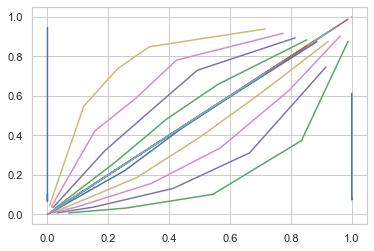

In [20]:
for plot in plots:
    plt.plot(plot[0], plot[1])
    plt.plot(plot[0], plot[0])
    
plt.show()

In [21]:
from pacmagic.visualizing.model_plots import plot_calibration_curve

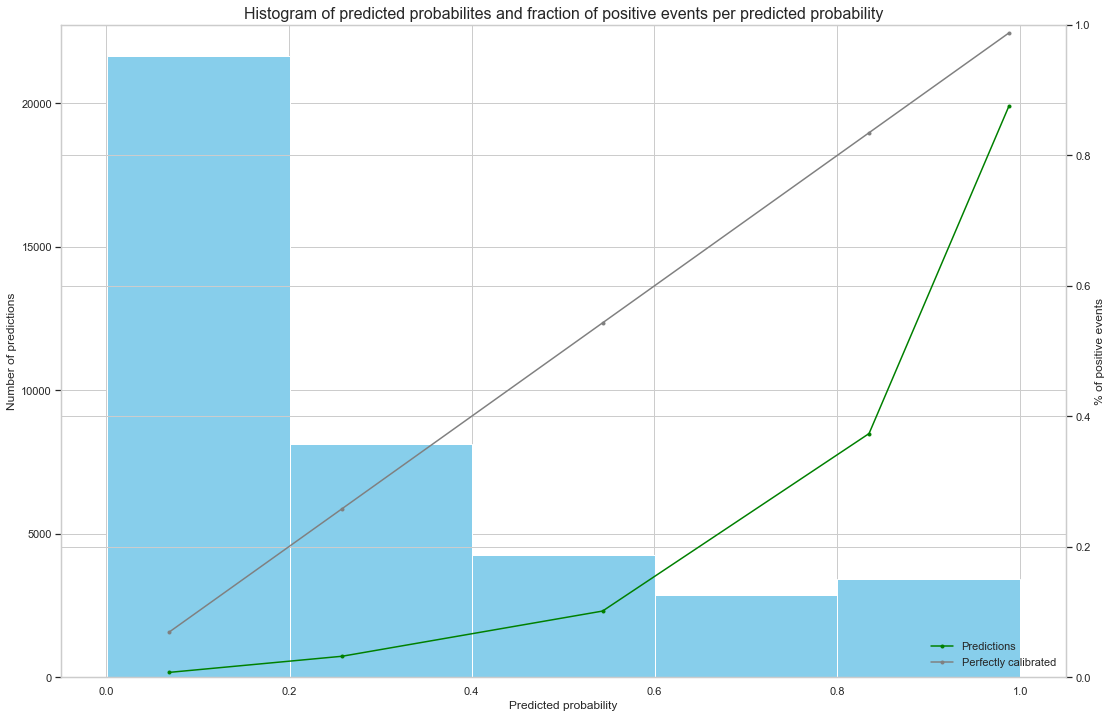

In [22]:
plot_calibration_curve(y_train, outputs[1].detach().numpy())

In [23]:
outputs_val = torch.stack([torch.sigmoid(output_val.squeeze()) for output_val in outputs_val], dim=1).detach().numpy().round(3)

In [24]:
# optimal cutoff point
cutoff = np.percentile(outputs_val[:, 5], 100 * (1-y_train.values.mean()))
cutoff

0.2525190085891604

In [25]:
preds = (outputs_val > cutoff)

In [26]:
(preds == np.repeat(y_test.values, 11, axis=1)).mean(axis=0)

array([0.087782  , 0.74826893, 0.85459013, 0.90283672, 0.92115256,
       0.93544784, 0.93835157, 0.94103194, 0.94013849, 0.93276748,
       0.912218  ])

In [27]:
preds_50 = preds[:, 5]

In [28]:
(preds_50.squeeze() == y_test.values.squeeze()).mean()

0.9354478445387536

In [29]:
quantiles

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [30]:
(preds == np.repeat(y_test.values, 11, axis=1)).any(axis=1).mean()

1.0

In [63]:
(preds[:, 1: 10] == np.repeat(y_test.values, 9, axis=1)).any(axis=1).mean()

0.9888318070136252

In [64]:
preds[:, 1].mean(), preds[:, 9].mean()

(0.3198570471297744, 0.023229841411659593)

In [65]:
(preds[:, 2 : 9] == np.repeat(y_test.values, 7, axis=1)).any(axis=1).mean()

0.9774402501675229

In [66]:
preds[:, 2].mean(), preds[:, 8].mean()

(0.1987938351574715, 0.03864194773285683)

In [35]:
(preds[:, 3:  8] == np.repeat(y_test.values, 5, axis=1)).any(axis=1).mean()

0.9647085101630556

In [67]:
preds[:, 3].mean(), preds[:, 7].mean()

(0.13893232075050257, 0.053383962474871566)

In [37]:
(preds[:, 4 : 7] == np.repeat(y_test.values, 3, axis=1)).any(axis=1).mean()

0.9504132231404959

In [68]:
preds[:, 4].mean(), preds[:, 6].mean()

(0.10676792494974313, 0.06544561090015635)

In [39]:
(preds[:, 5:6] == np.repeat(y_test.values, 2, axis=1)).any(axis=1).mean()

0.9354478445387536

In [69]:
preds[:, 5].mean(), preds[:, 5].mean()

(0.08398481125753852, 0.08398481125753852)

In [70]:
(preds_50.squeeze() == y_test.values.squeeze()).mean()

0.9354478445387536

In [42]:
uncertainties = []

In [44]:
uncertainties = outputs_val[:, 4] - outputs_val[:, 6]

In [45]:
preds_50 == y_test.values

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [46]:
outputs_val[:, 5][preds_50 == y_test.squeeze().values]

array([0.006, 0.013, 0.084, ..., 0.015, 0.04 , 0.04 ], dtype=float32)

(0.11825605, 0.029323304)

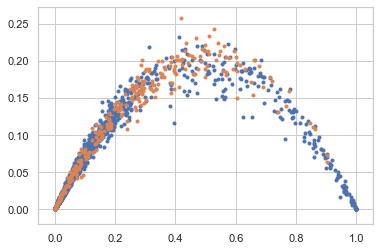

In [47]:
plt.scatter(outputs_val[:, 5][preds_50 == y_test.squeeze().values], uncertainties[preds_50 == y_test.squeeze().values], marker='.')


plt.scatter(outputs_val[:, 5][preds_50 != y_test.squeeze().values], uncertainties[preds_50 != y_test.squeeze().values], marker='.')


uncertainties[preds_50 != y_test.squeeze().values].mean(), uncertainties[preds_50 == y_test.squeeze().values].mean()


In [48]:
y_true = y_test.values.squeeze(-1)
y_prob = outputs_val[:, 5]
y_unc = uncertainties

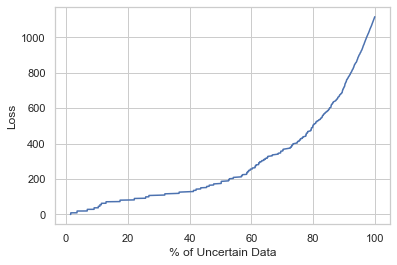

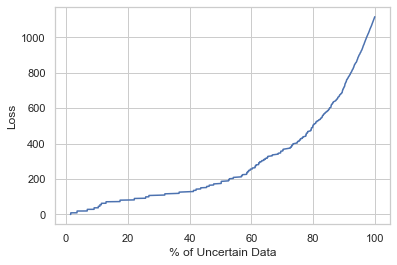

In [49]:
make_performance_uncertainty_plot(y_true, y_prob, y_unc, 'Loss', performance_fn_args={'reduction': 'sum'})

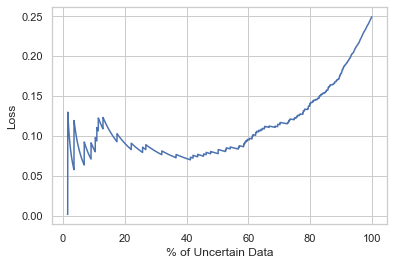

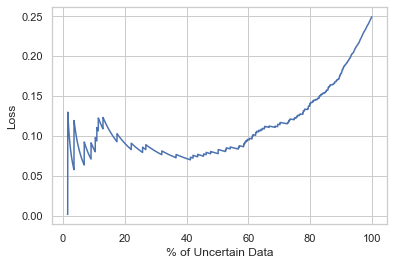

In [50]:
make_performance_uncertainty_plot(y_true, y_prob, y_unc, 'Loss', performance_fn_args={'reduction': 'mean'})

In [51]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [52]:
def asymmetric_entropy(p, w):
    return (p * (1 - p)) / ((-2 * w + 1) * p + w ** 2)


In [53]:
uncertainties = asymmetric_entropy(outputs_val[:, 5], y_train.values.mean())

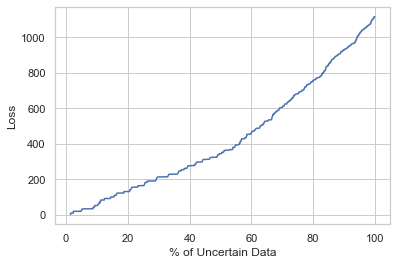

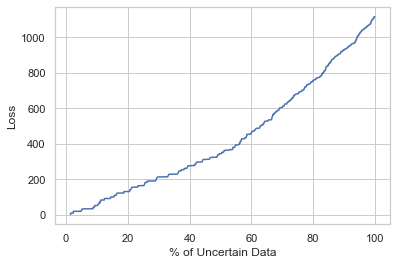

In [55]:
make_performance_uncertainty_plot(y_true, y_prob, uncertainties, 'Loss', performance_fn_args={'reduction': 'sum'})

In [58]:
cross_entropy(y_true, y_prob, reduction='sum')

1116.8834427737165

In [59]:
# loss at 50%
y_50 = y_true[y_unc.argsort()[:int(0.5 * len(y_unc))]]
y_prob_50 = y_prob[y_unc.argsort()[:int(0.5 * len(y_unc))]]

In [60]:
cross_entropy(y_50, y_prob_50, reduction='sum')

174.65215510805137